# Import Needed Libraries:
---

In [1]:
!pip install pingouin

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pingouin as pg

from scipy.stats import chi2_contingency

warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 8.6 MB/s eta 0:00:00


# Data Connections and Transfromations:
---

## Data Connections

In [2]:
# Reading the three dataframes
Consumption_dfs=[]
for i in range(1,4):
  Consumption_df=pd.read_csv(f'/content/drive/MyDrive/Data/Final Project/Sites Energy Consumption Part_00{i}.csv')
  Consumption_dfs.append(Consumption_df)


In [3]:
# Concat the three dataframes

Consumption_df=pd.concat(Consumption_dfs)

Consumption_df.reset_index(drop=True,inplace=True)

In [4]:
Consumption_df

,cell_id,DateTime,KWH/hh (per half hour),site_id,region
0,MAC000002,"00:00:00 13,01,01",0.219,A,A
1,MAC000002,"00:30:00 13,01,01",0.241,A,A
2,MAC000002,"01:00:00 13,01,01",0.191,A,A
3,MAC000002,"01:30:00 13,01,01",0.235,A,A
4,MAC000002,"02:00:00 13,01,01",0.182,A,A
...,...,...,...,...,...
1380247,MAC000100,"18:30:00 13,20,12",0.260,N,B
1380248,MAC000100,"19:00:00 13,20,12",0.267,N,B
1380249,MAC000100,"19:30:00 13,20,12",0.274,N,B
1380250,MAC000100,"20:00:00 13,20,12",0.312,N,B


In [5]:
# Removing Leading and Trailing Spaces from Column Names in the DataFrame
Consumption_df.columns = Consumption_df.columns.str.strip()


In [6]:
# Display summary information about the DataFrame, including the number of rows, non-null counts and data types.
Consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380252 entries, 0 to 1380251
Data columns (total 5 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   cell_id                 1380252 non-null  object 
 1   DateTime                1380252 non-null  object 
 2   KWH/hh (per half hour)  1380252 non-null  float64
 3   site_id                 1380252 non-null  object 
 4   region                  1380252 non-null  object 
dtypes: float64(1), object(4)
memory usage: 52.7+ MB


We observe that the `DateTime` column requires type correction from object to datetime

In [7]:
# Try to infer the format automatically for mixed formats
Consumption_df['DateTime'] = pd.to_datetime(Consumption_df['DateTime'], errors='coerce', format='%H:%M:%S %y,%d,%m')

In [8]:
Consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380252 entries, 0 to 1380251
Data columns (total 5 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   cell_id                 1380252 non-null  object        
 1   DateTime                1380252 non-null  datetime64[ns]
 2   KWH/hh (per half hour)  1380252 non-null  float64       
 3   site_id                 1380252 non-null  object        
 4   region                  1380252 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 52.7+ MB


In [9]:
#Check Duplicates
Consumption_df[Consumption_df.duplicated()]

,cell_id,DateTime,KWH/hh (per half hour),site_id,region
961,MAC000002,2013-01-21,0.210,A,A
2450,MAC000002,2013-02-21,0.216,A,A
3939,MAC000002,2013-03-24,0.486,A,A
5428,MAC000002,2013-04-24,0.147,A,A
6917,MAC000002,2013-05-25,0.170,A,A
...,...,...,...,...,...
1373150,MAC000100,2013-07-26,0.104,N,B
1374639,MAC000100,2013-08-26,0.142,N,B
1376128,MAC000100,2013-09-26,0.112,N,B
1377617,MAC000100,2013-10-27,0.104,N,B


In [10]:
Consumption_df.drop_duplicates(inplace=True)

In [11]:
Consumption_df

,cell_id,DateTime,KWH/hh (per half hour),site_id,region
0,MAC000002,2013-01-01 00:00:00,0.219,A,A
1,MAC000002,2013-01-01 00:30:00,0.241,A,A
2,MAC000002,2013-01-01 01:00:00,0.191,A,A
3,MAC000002,2013-01-01 01:30:00,0.235,A,A
4,MAC000002,2013-01-01 02:00:00,0.182,A,A
...,...,...,...,...,...
1380247,MAC000100,2013-12-20 18:30:00,0.260,N,B
1380248,MAC000100,2013-12-20 19:00:00,0.267,N,B
1380249,MAC000100,2013-12-20 19:30:00,0.274,N,B
1380250,MAC000100,2013-12-20 20:00:00,0.312,N,B


In [12]:
Consumption_df['cell_id'].value_counts()

,count
cell_id,
MAC000099,17520
MAC000091,17520
MAC000027,17520
MAC000018,17520
MAC000019,17520
...,...
MAC000095,13055
MAC000063,12767
MAC000080,7103


By viewing the value counts of each cell, we observed that the total number of entries should be 17,520. This indicates that some cells have missing timestamps.So we should handle that

In [13]:
# Define the full date range for the year
full_year_range = pd.date_range(start='2013-01-01 00:00:00', end='2013-12-31 23:30:00', freq='30T')

# Create a full DataFrame with all combinations of cell_id and full year timestamps
cell_ids = Consumption_df['cell_id'].unique()  # Unique cell IDs
all_timestamps = pd.DataFrame(
    [(cell_id, timestamp) for cell_id in cell_ids for timestamp in full_year_range],
    columns=['cell_id', 'DateTime']
)

In [14]:
all_timestamps

,cell_id,DateTime
0,MAC000002,2013-01-01 00:00:00
1,MAC000002,2013-01-01 00:30:00
2,MAC000002,2013-01-01 01:00:00
3,MAC000002,2013-01-01 01:30:00
4,MAC000002,2013-01-01 02:00:00
...,...,...
1436635,MAC000100,2013-12-31 21:30:00
1436636,MAC000100,2013-12-31 22:00:00
1436637,MAC000100,2013-12-31 22:30:00
1436638,MAC000100,2013-12-31 23:00:00


In [15]:
all_timestamps[all_timestamps['cell_id']=='MAC000016']

,cell_id,DateTime
192720,MAC000016,2013-01-01 00:00:00
192721,MAC000016,2013-01-01 00:30:00
192722,MAC000016,2013-01-01 01:00:00
192723,MAC000016,2013-01-01 01:30:00
192724,MAC000016,2013-01-01 02:00:00
...,...,...
210235,MAC000016,2013-12-31 21:30:00
210236,MAC000016,2013-12-31 22:00:00
210237,MAC000016,2013-12-31 22:30:00
210238,MAC000016,2013-12-31 23:00:00


In [16]:
len(all_timestamps)

1436640

In [17]:

# Merge the full timestamp range with the original dataset
df_full = pd.merge(all_timestamps, Consumption_df, on=['cell_id', 'DateTime'], how='left')
df_full




,cell_id,DateTime,KWH/hh (per half hour),site_id,region
0,MAC000002,2013-01-01 00:00:00,0.219,A,A
1,MAC000002,2013-01-01 00:30:00,0.241,A,A
2,MAC000002,2013-01-01 01:00:00,0.191,A,A
3,MAC000002,2013-01-01 01:30:00,0.235,A,A
4,MAC000002,2013-01-01 02:00:00,0.182,A,A
...,...,...,...,...,...
1436635,MAC000100,2013-12-31 21:30:00,NaN,NaN,NaN
1436636,MAC000100,2013-12-31 22:00:00,NaN,NaN,NaN
1436637,MAC000100,2013-12-31 22:30:00,NaN,NaN,NaN
1436638,MAC000100,2013-12-31 23:00:00,NaN,NaN,NaN


In [18]:
# Fill missing `KWH/hh (per half hour)` with the median for each `cell_id`
df_full['KWH/hh (per half hour)'] = df_full.groupby('cell_id')['KWH/hh (per half hour)'].transform(
    lambda group: group.fillna(group.median())
)

# Check the length for a specific cell_id
print(f"Number of timestamps for 'MAC000016': {len(df_full[df_full['cell_id'] == 'MAC000016'])}")

Number of timestamps for 'MAC000016': 17520


In [19]:
df_full

,cell_id,DateTime,KWH/hh (per half hour),site_id,region
0,MAC000002,2013-01-01 00:00:00,0.219,A,A
1,MAC000002,2013-01-01 00:30:00,0.241,A,A
2,MAC000002,2013-01-01 01:00:00,0.191,A,A
3,MAC000002,2013-01-01 01:30:00,0.235,A,A
4,MAC000002,2013-01-01 02:00:00,0.182,A,A
...,...,...,...,...,...
1436635,MAC000100,2013-12-31 21:30:00,0.156,NaN,NaN
1436636,MAC000100,2013-12-31 22:00:00,0.156,NaN,NaN
1436637,MAC000100,2013-12-31 22:30:00,0.156,NaN,NaN
1436638,MAC000100,2013-12-31 23:00:00,0.156,NaN,NaN


In [20]:
df_full['site_id'] = df_full.groupby('cell_id')['site_id'].transform(lambda group: group.ffill().bfill())
df_full['region'] = df_full.groupby('cell_id')['region'].transform(lambda group: group.ffill().bfill())

In [21]:
df_full

,cell_id,DateTime,KWH/hh (per half hour),site_id,region
0,MAC000002,2013-01-01 00:00:00,0.219,A,A
1,MAC000002,2013-01-01 00:30:00,0.241,A,A
2,MAC000002,2013-01-01 01:00:00,0.191,A,A
3,MAC000002,2013-01-01 01:30:00,0.235,A,A
4,MAC000002,2013-01-01 02:00:00,0.182,A,A
...,...,...,...,...,...
1436635,MAC000100,2013-12-31 21:30:00,0.156,N,B
1436636,MAC000100,2013-12-31 22:00:00,0.156,N,B
1436637,MAC000100,2013-12-31 22:30:00,0.156,N,B
1436638,MAC000100,2013-12-31 23:00:00,0.156,N,B


In [22]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436640 entries, 0 to 1436639
Data columns (total 5 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   cell_id                 1436640 non-null  object        
 1   DateTime                1436640 non-null  datetime64[ns]
 2   KWH/hh (per half hour)  1436640 non-null  float64       
 3   site_id                 1436640 non-null  object        
 4   region                  1436640 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 54.8+ MB


# Handeling Anamoly values
---

<Axes: xlabel='KWH/hh (per half hour)'>

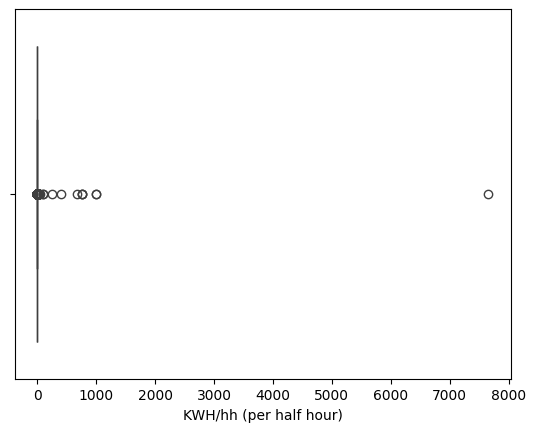

In [23]:
sns.boxplot(df_full['KWH/hh (per half hour)'], orient = 'h')

In [24]:
# Anamoly Detction

# IQR
q1 = np.quantile(df_full['KWH/hh (per half hour)'], 0.25)
q3 = np.quantile(df_full['KWH/hh (per half hour)'], 0.75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

df_full['value_check'] = np.where((df_full['KWH/hh (per half hour)'] > upper_limit) | (df_full['KWH/hh (per half hour)'] < lower_limit), 1, 0)

print(df_full['value_check'].value_counts())

# Treatment (replacing with Median)
df_full['New_KWH/hh_(per half hour)'] = np.where(df_full['value_check'] == 1, np.median(df_full['KWH/hh (per half hour)']), df_full['KWH/hh (per half hour)'])

value_check
0    1311968
1     124672
Name: count, dtype: int64


<Axes: xlabel='New_KWH/hh_(per half hour)'>

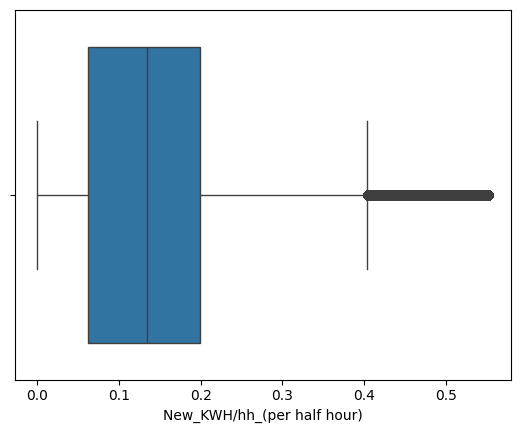

In [25]:
sns.boxplot(df_full['New_KWH/hh_(per half hour)'], orient = 'h')

# Integrate with Demand Table
---

In [26]:
Demand_df=pd.read_excel('/content/drive/MyDrive/Data/Final Project/Demand.xlsx')

In [27]:
Demand_df

Demand_df[Demand_df.duplicated()]

,DemandDateTime,Demand


In [28]:
Demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DemandDateTime  17520 non-null  datetime64[ns]
 1   Demand          17520 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 273.9+ KB


In [29]:
Demand_df

,DemandDateTime,Demand
0,2013-01-01 00:00:00,Normal
1,2013-01-01 00:30:00,Normal
2,2013-01-01 01:00:00,Normal
3,2013-01-01 01:30:00,Normal
4,2013-01-01 02:00:00,Normal
...,...,...
17515,2013-12-31 21:30:00,Normal
17516,2013-12-31 22:00:00,Normal
17517,2013-12-31 22:30:00,Normal
17518,2013-12-31 23:00:00,Normal


In [30]:
Demand_df['Demand'].value_counts()

,count
Demand,
Normal,15069
Low,1660
High,785
high,3
normal,2
Normall,1


In [31]:
Demand_df['Demand']=Demand_df['Demand'].replace("normal","Normal")
Demand_df['Demand']=Demand_df['Demand'].replace("high","High")
Demand_df['Demand']=Demand_df['Demand'].replace("Normall","Normal")

In [32]:
Demand_df['Demand'].value_counts()

,count
Demand,
Normal,15072
Low,1660
High,788


In [33]:
df=pd.merge(df_full,Demand_df,left_on='DateTime',right_on='DemandDateTime',how='left')

In [34]:
df

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,value_check,New_KWH/hh_(per half hour),DemandDateTime,Demand
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,0,0.219,2013-01-01 00:00:00,Normal
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,0,0.241,2013-01-01 00:30:00,Normal
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,0,0.191,2013-01-01 01:00:00,Normal
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,0,0.235,2013-01-01 01:30:00,Normal
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,0,0.182,2013-01-01 02:00:00,Normal
...,...,...,...,...,...,...,...,...,...
1436635,MAC000100,2013-12-31 21:30:00,0.156,N,B,0,0.156,2013-12-31 21:30:00,Normal
1436636,MAC000100,2013-12-31 22:00:00,0.156,N,B,0,0.156,2013-12-31 22:00:00,Normal
1436637,MAC000100,2013-12-31 22:30:00,0.156,N,B,0,0.156,2013-12-31 22:30:00,Normal
1436638,MAC000100,2013-12-31 23:00:00,0.156,N,B,0,0.156,2013-12-31 23:00:00,Normal


In [35]:
df.drop('DemandDateTime',axis=1,inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436640 entries, 0 to 1436639
Data columns (total 8 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   cell_id                     1436640 non-null  object        
 1   DateTime                    1436640 non-null  datetime64[ns]
 2   KWH/hh (per half hour)      1436640 non-null  float64       
 3   site_id                     1436640 non-null  object        
 4   region                      1436640 non-null  object        
 5   value_check                 1436640 non-null  int64         
 6   New_KWH/hh_(per half hour)  1436640 non-null  float64       
 7   Demand                      1436640 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 87.7+ MB


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436640 entries, 0 to 1436639
Data columns (total 8 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   cell_id                     1436640 non-null  object        
 1   DateTime                    1436640 non-null  datetime64[ns]
 2   KWH/hh (per half hour)      1436640 non-null  float64       
 3   site_id                     1436640 non-null  object        
 4   region                      1436640 non-null  object        
 5   value_check                 1436640 non-null  int64         
 6   New_KWH/hh_(per half hour)  1436640 non-null  float64       
 7   Demand                      1436640 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 87.7+ MB


In [38]:
#Cost Column Calculations
High_factor =77.21
normal_factor =19.46
Low_factor = 6.89
df['cost']=np.where(df['Demand']=='High',df['New_KWH/hh_(per half hour)']*High_factor,
                    np.where(df['Demand']=='Normal',df['New_KWH/hh_(per half hour)']*normal_factor,
                             df['New_KWH/hh_(per half hour)']*Low_factor))

# Feature Engineering
---

In [39]:
# Extract additional time-based features
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.day_name()


In [40]:
df

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,value_check,New_KWH/hh_(per half hour),Demand,cost,Year,Month,Day,Hour,DayOfWeek
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,0,0.219,Normal,4.26174,2013,1,1,0,Tuesday
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,0,0.241,Normal,4.68986,2013,1,1,0,Tuesday
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,0,0.191,Normal,3.71686,2013,1,1,1,Tuesday
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,0,0.235,Normal,4.57310,2013,1,1,1,Tuesday
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,0,0.182,Normal,3.54172,2013,1,1,2,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436635,MAC000100,2013-12-31 21:30:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,21,Tuesday
1436636,MAC000100,2013-12-31 22:00:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,22,Tuesday
1436637,MAC000100,2013-12-31 22:30:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,22,Tuesday
1436638,MAC000100,2013-12-31 23:00:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,23,Tuesday


In [41]:
#Extract Season
df['Season'] = np.select(
        [
            df['Month'].isin([12, 1, 2]),   # Winter
            df['Month'].isin([3, 4, 5]),    # Spring
            df['Month'].isin([6, 7, 8]),    # Summer
            df['Month'].isin([9, 10, 11])   # Autumn
        ],
        ['Winter', 'Spring', 'Summer', 'Autumn'],
        default='Unknown'
    )


In [42]:
df

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,value_check,New_KWH/hh_(per half hour),Demand,cost,Year,Month,Day,Hour,DayOfWeek,Season
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,0,0.219,Normal,4.26174,2013,1,1,0,Tuesday,Winter
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,0,0.241,Normal,4.68986,2013,1,1,0,Tuesday,Winter
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,0,0.191,Normal,3.71686,2013,1,1,1,Tuesday,Winter
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,0,0.235,Normal,4.57310,2013,1,1,1,Tuesday,Winter
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,0,0.182,Normal,3.54172,2013,1,1,2,Tuesday,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436635,MAC000100,2013-12-31 21:30:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,21,Tuesday,Winter
1436636,MAC000100,2013-12-31 22:00:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,22,Tuesday,Winter
1436637,MAC000100,2013-12-31 22:30:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,22,Tuesday,Winter
1436638,MAC000100,2013-12-31 23:00:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,23,Tuesday,Winter


In [43]:
# Extract TimeOfDay
df['TimeOfDay'] = np.select(
        [
            (df['Hour'] >= 5) & (df['Hour'] < 12),    # Morning
            (df['Hour'] >= 12) & (df['Hour'] < 17),   # Afternoon
            (df['Hour'] >= 17) & (df['Hour'] < 21),   # Evening
            (df['Hour'] >= 21) | (df['Hour'] < 5)     # Night
        ],
        ['Morning', 'Afternoon', 'Evening', 'Night'],
        default='Unknown'
    )


In [44]:
df

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,value_check,New_KWH/hh_(per half hour),Demand,cost,Year,Month,Day,Hour,DayOfWeek,Season,TimeOfDay
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,0,0.219,Normal,4.26174,2013,1,1,0,Tuesday,Winter,Night
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,0,0.241,Normal,4.68986,2013,1,1,0,Tuesday,Winter,Night
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,0,0.191,Normal,3.71686,2013,1,1,1,Tuesday,Winter,Night
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,0,0.235,Normal,4.57310,2013,1,1,1,Tuesday,Winter,Night
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,0,0.182,Normal,3.54172,2013,1,1,2,Tuesday,Winter,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436635,MAC000100,2013-12-31 21:30:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,21,Tuesday,Winter,Night
1436636,MAC000100,2013-12-31 22:00:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,22,Tuesday,Winter,Night
1436637,MAC000100,2013-12-31 22:30:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,22,Tuesday,Winter,Night
1436638,MAC000100,2013-12-31 23:00:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,23,Tuesday,Winter,Night


In [45]:
# Define thresholds for categorizing consumption into Low, Normal, High
threshold_low = df_full['New_KWH/hh_(per half hour)'].quantile(0.33)  # Low: below 33rd percentile
threshold_high = df_full['New_KWH/hh_(per half hour)'].quantile(0.67)  # High: above 67th percentile

# Categorize energy consumption
def categorize_consumption(value):
    if value < threshold_low:
        return 'Low'
    elif value < threshold_high:
        return 'Normal'
    else:
        return 'High'

df['Consumption_Category'] = df['New_KWH/hh_(per half hour)'].apply(categorize_consumption)


# Business Insights
---

In [46]:
pivot_table_1 = pd.pivot_table(
    df,
    values='New_KWH/hh_(per half hour)',
    index='region',
    columns='TimeOfDay',
    aggfunc='mean'
).reset_index()

pivot_table_1

TimeOfDay,region,Afternoon,Evening,Morning,Night
0,A,0.151276,0.161605,0.149512,0.142738
1,B,0.147279,0.182309,0.129631,0.115514
2,C,0.174541,0.211039,0.166688,0.156020
3,D,0.141758,0.163733,0.125157,0.109915


The pivot table shows the average energy consumption for each region (A, B, C, D) during different times of day (Afternoon, Evening, Morning, Night).


*   Evening generally has the highest energy consumption across all regions.

*   Night consistently has the lowest consumption, indicating off-peak usage.
*   Region C shows the highest variability in consumption across
different times of day.



In [47]:
pivot_table_2 = pd.pivot_table(
    df,
    values='cell_id',
    index='region',
    columns='Consumption_Category',
    aggfunc='count'
).reset_index()

pivot_table_2


Consumption_Category,region,High,Low,Normal
0,A,191680,189369,197111
1,B,129596,171807,154117
2,C,147144,94963,125813
3,D,6624,14264,14152


The pivot table shows the count of entries in each region for energy consumption categories (High, Low, Normal).




*   Region A: Balanced across all categories.
*   Region B: More Low consumption.


*   Region C: Mostly High consumption.

*   Region D: Predominantly Low consumption with very few High entries.




In [48]:
pivot_table_3 = pd.pivot_table(
    df,
    values='cost',
    index='region',
    columns='Demand',
    aggfunc='sum'
)

pivot_table_3

Demand,High,Low,Normal
region,,,
A,311181.47046,56904.54445,1.444413e+06
B,250592.46716,40302.88964,1.040817e+06
C,245396.15695,41269.88736,1.054207e+06
D,17961.20788,2901.87508,7.589692e+04


The pivot table shows total demand across regions and energy consumption categories (High, Low, Normal).


*  Normal consumption has the highest demand in all regions.
*  Region D has the lowest overall demand, especially for High consumption.

In [49]:
pivot_table_4 = pd.pivot_table(
    df,
    values='New_KWH/hh_(per half hour)',
    index='Year',
    columns='Season',
    aggfunc='sum'
)

pivot_table_4

Season,Autumn,Spring,Summer,Winter
Year,,,,
2013,53130.105,55185.957,51127.582,57545.486




*   Peak Consumption: High consumption in Winter, low in summer months .

*   Optimization: Focus on energy savings during low-demand months.
*  Pricing: Adjust rates based on seasonal demand.


*   Forecasting: Plan for future energy needs using seasonal data.





In [50]:
pivot_table_5 = pd.pivot_table(
    df,
    values='New_KWH/hh_(per half hour)',
    index='Hour',
    aggfunc='mean'
)

pivot_table_5

,New_KWH/hh_(per half hour)
Hour,
0,0.131191
1,0.118260
2,0.111742
3,0.107499
4,0.107816
5,0.117180
6,0.133215
7,0.149199
8,0.159186


In [51]:
pivot_table_6= df.pivot_table(
    index='region',
    values=['New_KWH/hh_(per half hour)', 'cost'],
    aggfunc='sum'
)

print(pivot_table_6)


        New_KWH/hh_(per half hour)          cost
region                                          
A                        86514.042  1.812499e+06
B                        62579.999  1.331712e+06
C                        63341.139  1.340873e+06
D                         4553.950  9.676000e+04


# Data Visualizations

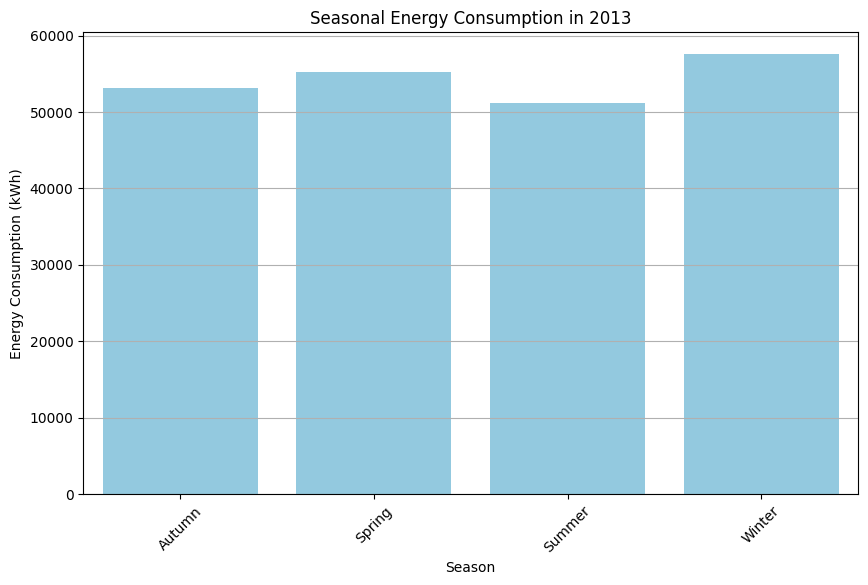

In [52]:
# Set the plot size
plt.figure(figsize=(10, 6))

#Transpose the table
pivot_table_4 = pivot_table_4.T

sns.barplot(x=pivot_table_4.index, y=pivot_table_4[2013], color='skyblue')

plt.title('Seasonal Energy Consumption in 2013')
plt.xlabel('Season')
plt.ylabel('Energy Consumption (kWh)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')

# Show the plot
plt.show()

Text(0, 0.5, '')

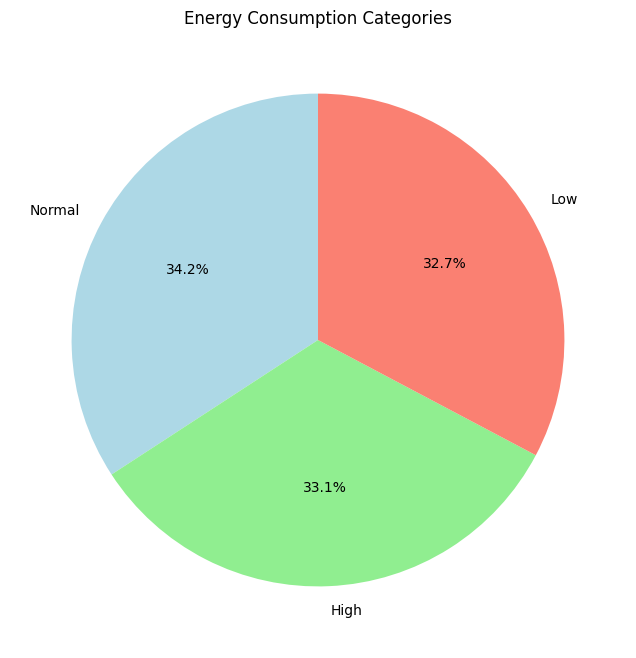

In [53]:
plt.figure(figsize=(8, 8))
df['Consumption_Category'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'salmon'], startangle=90)
plt.title('Energy Consumption Categories')
plt.ylabel('')

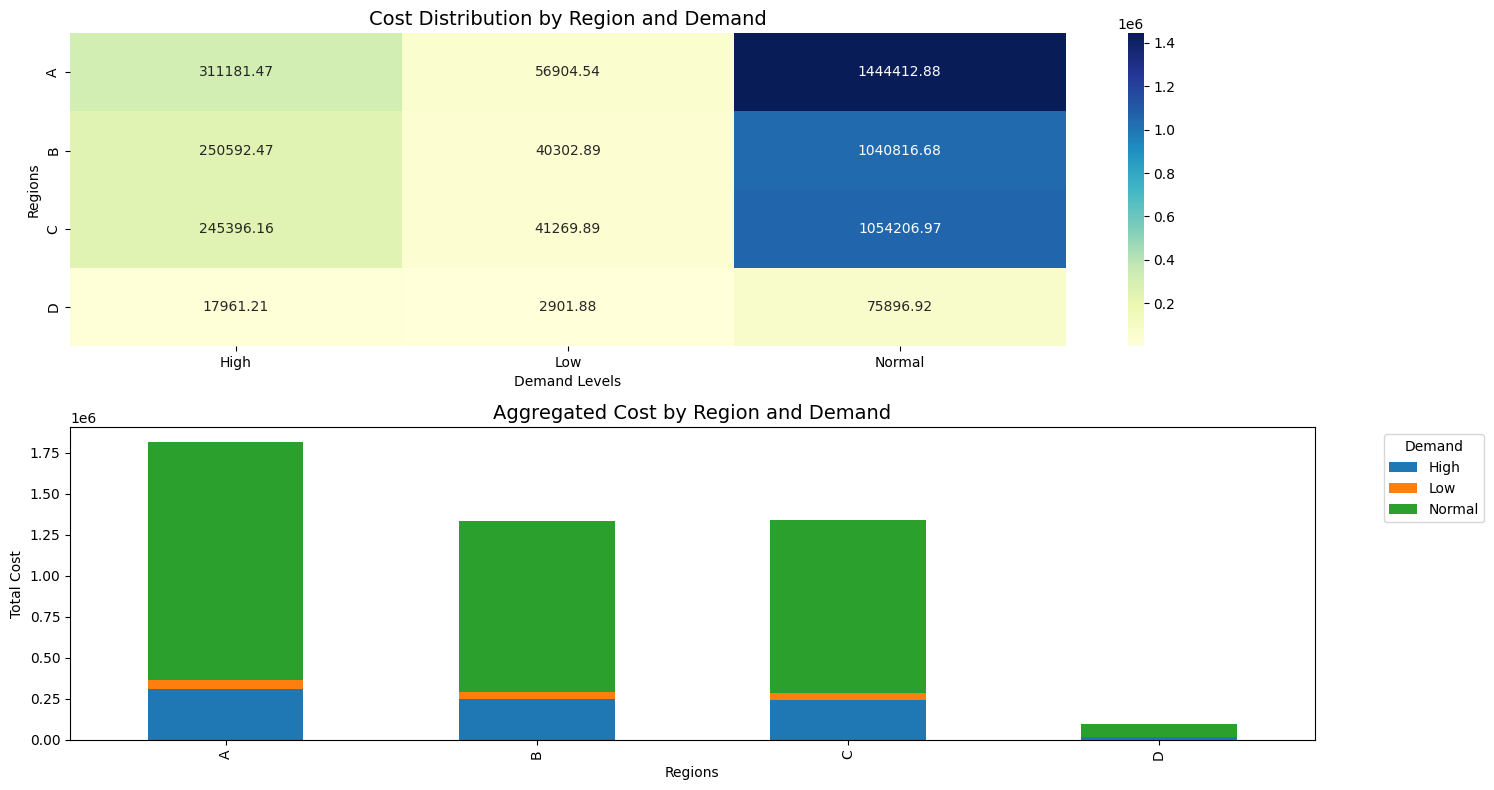


Descriptive Statistics of Pivot Table:
Demand           High           Low        Normal
count        4.000000      4.000000  4.000000e+00
mean    206282.825612  35344.799132  9.038334e+05
std     129050.318892  22927.823499  5.828326e+05
min      17961.207880   2901.875080  7.589692e+04
25%     188537.419682  30952.636000  7.995867e+05
50%     247994.312055  40786.388500  1.047512e+06
75%     265739.717985  45178.551632  1.151758e+06
max     311181.470460  56904.544450  1.444413e+06

Total Cost by Region:
region
A    1.812499e+06
B    1.331712e+06
C    1.340873e+06
D    9.676000e+04
dtype: float64


In [54]:
# Visualization of Pivot Table
plt.figure(figsize=(15, 8))

# Heatmap Visualization
plt.subplot(2, 1, 1)
sns.heatmap(pivot_table_3, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Cost Distribution by Region and Demand', fontsize=14)
plt.xlabel('Demand Levels')
plt.ylabel('Regions')

# Stacked Bar Chart
plt.subplot(2, 1, 2)
pivot_table_3.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Aggregated Cost by Region and Demand', fontsize=14)
plt.xlabel('Regions')
plt.ylabel('Total Cost')
plt.legend(title='Demand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show plots
plt.show()

# Descriptive Statistics
print("\nDescriptive Statistics of Pivot Table:")
print(pivot_table_3.describe())

# Total Cost by Region
print("\nTotal Cost by Region:")
print(pivot_table_3.sum(axis=1))




# ANOVA Test
---

In [55]:

# Apply ANOVA Test
anova=pg.anova(data = df, dv = 'New_KWH/hh_(per half hour)', between = 'region')
p_value=anova['p-unc'][0]
# Decision based on p-value
if p_value < 0.05:
    print('Reject H0: There is a significant relationship between region and energy consumption.')
else:
    print('Fail to reject H0: No significant relationship between region and energy consumption.')

Reject H0: There is a significant relationship between region and energy consumption.


### **ANOVA Test Limitations**:

1.  **Lacks Pairwise Comparisons**: ANOVA does not provide details on relationships between individual groups. A pairwise test is needed for specific group-to-group comparisons.
    
2.  **Handles Only Numerical Data**: ANOVA is limited to numerical values and cannot directly analyze categorical data.



# Chi-Squared Test

In [56]:

# Create a contingency table
contingency_table = pd.crosstab(df['TimeOfDay'], df['Consumption_Category'])

# Perform Chi-Squared Test of Independence
chi2_stat, p_value, dof, expected_freq = chi2_contingency(contingency_table)

# Print the results
print(f"P-Value: {p_value}")


# Decision based on p-value
if p_value < 0.05:
    print('Reject H0: There is a significant relationship between TimeOfDay and energy consumption.')
else:
    print('Fail to reject H0: No significant relationship between TimeOfDay and energy consumption.')


P-Value: 0.0
Reject H0: There is a significant relationship between TimeOfDay and energy consumption.



**Chi-Squared Test Limitations**:

1.  **No Pairwise Comparisons**: Similar to ANOVA, Chi-squared only tests for overall independence and does not show specific relationships between individual categories.
    
2.  **Requires Categorical Data**: Chi-squared cannot handle numerical data directly and requires values to be grouped into categories

In [57]:
df

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,value_check,New_KWH/hh_(per half hour),Demand,cost,Year,Month,Day,Hour,DayOfWeek,Season,TimeOfDay,Consumption_Category
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,0,0.219,Normal,4.26174,2013,1,1,0,Tuesday,Winter,Night,High
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,0,0.241,Normal,4.68986,2013,1,1,0,Tuesday,Winter,Night,High
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,0,0.191,Normal,3.71686,2013,1,1,1,Tuesday,Winter,Night,High
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,0,0.235,Normal,4.57310,2013,1,1,1,Tuesday,Winter,Night,High
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,0,0.182,Normal,3.54172,2013,1,1,2,Tuesday,Winter,Night,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436635,MAC000100,2013-12-31 21:30:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,21,Tuesday,Winter,Night,Normal
1436636,MAC000100,2013-12-31 22:00:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,22,Tuesday,Winter,Night,Normal
1436637,MAC000100,2013-12-31 22:30:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,22,Tuesday,Winter,Night,Normal
1436638,MAC000100,2013-12-31 23:00:00,0.156,N,B,0,0.156,Normal,3.03576,2013,12,31,23,Tuesday,Winter,Night,Normal


# Choosing threshold and its impact
---

In [58]:

threshold = df['New_KWH/hh_(per half hour)'].quantile(0.33)

# Filter low-consumption cells
low_consumption_cells = df[df['New_KWH/hh_(per half hour)'] < threshold]



 #Calculate total cost savings
cost_saved = low_consumption_cells['cost'].sum()

# Output results
print(f"Threshold for low consumption: {threshold:.4f} kWh")
print(f"Total Cost Saved (EGP): {cost_saved:.2f}")


Threshold for low consumption: 0.0830 kWh
Total Cost Saved (EGP): 403437.36


# Saving The Data for the Dashboard

In [59]:
df.to_csv('/content/drive/MyDrive/final_data.csv', index=False)